In [1]:
"""
Title: Variational AutoEncoder
Author: [fchollet](https://twitter.com/fchollet)
Date created: 2020/05/03
Last modified: 2020/05/03
Description: Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.
Accelerator: GPU
"""

"""
## Setup
"""

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

"""
## Create a sampling layer
"""


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


"""
## Build the encoder
"""

latent_dim = 2

encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

"""
## Define the VAE as a `Model` with a custom `train_step`
"""


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


2023-09-26 18:26:01.246406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 18:26:01.310948: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-26 18:26:03.051405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-26 18:26:03.079468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] suc

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 4096)         0           ['conv2d_1[0][0]']               
                                                                                            

In [2]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 4096)              12288     
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 3)        867 

In [3]:
"""
## Train the VAE
"""

(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()

mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = mnist_digits.astype("float32") / 255

In [4]:
mnist_digits.shape

(60000, 32, 32, 3)

In [5]:
x_test.shape

(10000, 32, 32, 3)

In [6]:




vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

"""
## Display a grid of sampled digits
"""



Epoch 1/30


2023-09-26 18:26:06.706817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-09-26 18:26:07.506635: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x558e0124f8f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-26 18:26:07.506667: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2023-09-26 18:26:07.511456: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-26 18:26:07.632359: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 [==============================] - 7s 6ms/step - loss: 691.9337 - reconstruction_loss: 677.7352 - kl_loss: 2.9927
Epoch 2/30
469/469 [==============================] - 3s 5ms/step - loss: 669.6061 - reconstruction_loss: 666.5537 - kl_loss: 2.8593
Epoch 3/30
469/469 [==============================] - 2s 5ms/step - loss: 668.3988 - reconstruction_loss: 665.6169 - kl_loss: 2.4741
Epoch 4/30
469/469 [==============================] - 2s 5ms/step - loss: 668.1381 - reconstruction_loss: 665.2566 - kl_loss: 2.4761
Epoch 5/30
469/469 [==============================] - 3s 6ms/step - loss: 668.0239 - reconstruction_loss: 665.1117 - kl_loss: 2.4904
Epoch 6/30
469/469 [==============================] - 3s 5ms/step - loss: 667.3366 - reconstruction_loss: 664.8348 - kl_loss: 2.5445
Epoch 7/30
469/469 [==============================] - 2s 5ms/step - loss: 664.4115 - reconstruction_loss: 656.3418 - kl_loss: 4.2233
Epoch 8/30
469/469 [==============================] - 2s 5ms/step - loss: 656.75

ValueError: cannot reshape array of size 3072 into shape (32,32)

1/1 [==============================] - 0s 14ms/step


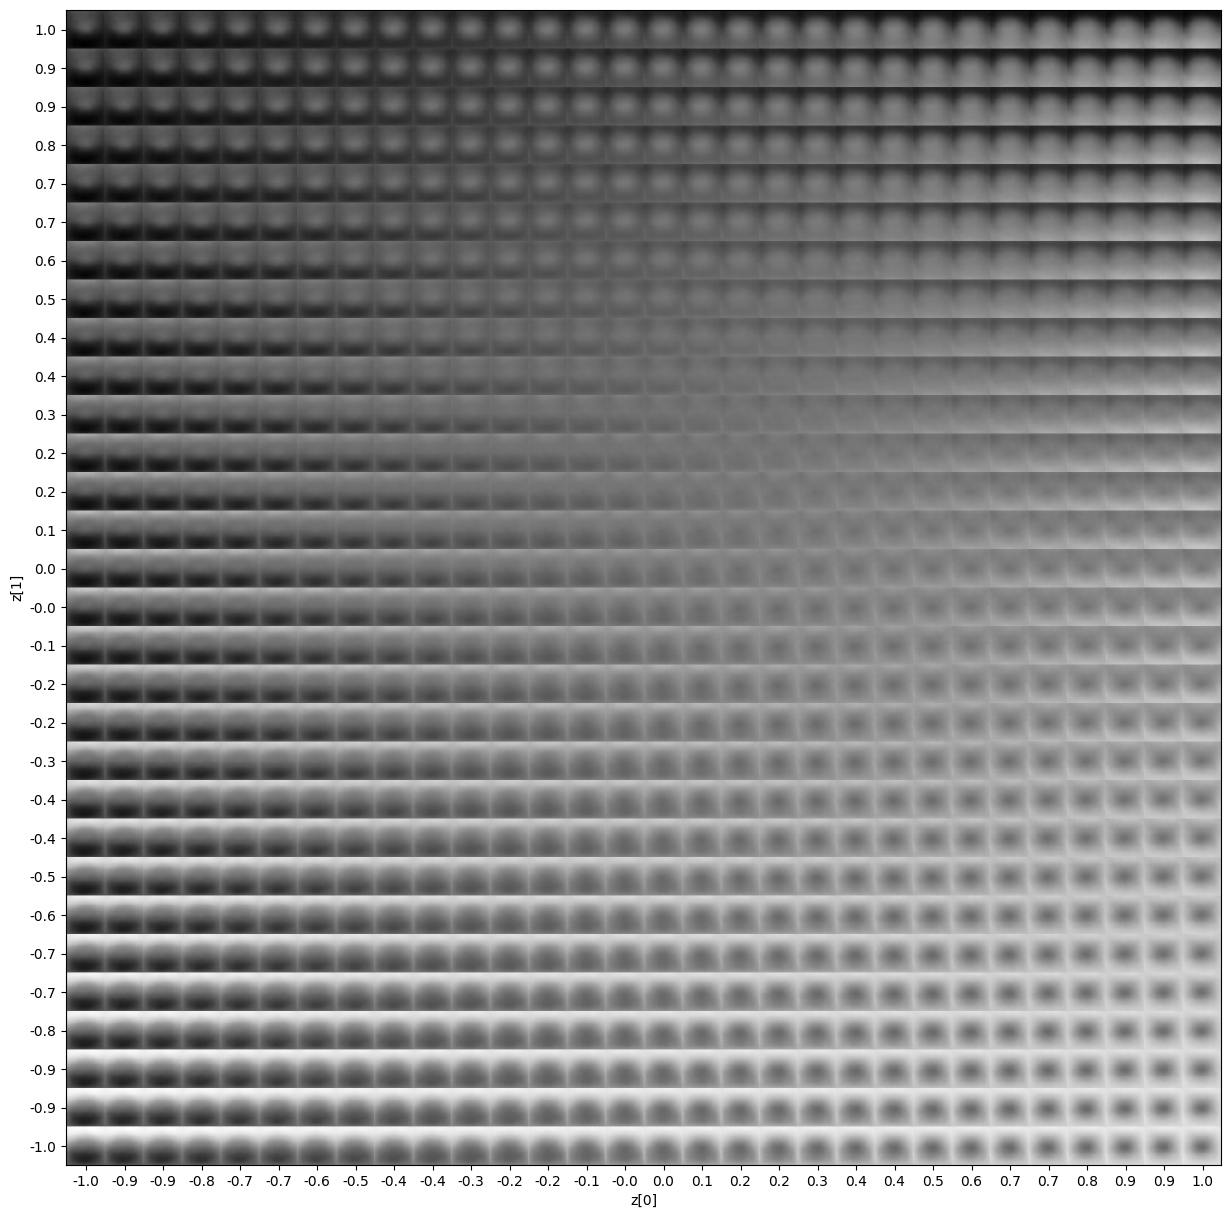

In [15]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display an n*n 2D manifold of digits
    digit_size = 32
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            x_decoded = x_decoded[0]
            b = x_decoded[..., 0]
            g = x_decoded[..., 1]
            r = x_decoded[..., 2]
            gray_image = 0.21 * r + 0.72 * g + 0.07 * b
            digit = gray_image.reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

"""
## Display how the latent space clusters different digit classes
"""


def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

#plot_label_clusters(vae, x_train, y_train)

In [23]:
x_decoded = vae.encoder.predict(x_test)


313/313 [==============================] - 0s 740us/step


ValueError: in user code:

    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "decoder" expects 1 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 2) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 2) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 2) dtype=float32>]


In [25]:
pics = vae.decoder.predict(x_decoded[0])

313/313 [==============================] - 0s 1ms/step


In [26]:
np.asarray(x_decoded).shape

(3, 10000, 2)

In [30]:
pic = pics[0] * 255

In [37]:
pic = pic.astype(int) 

In [35]:
from PIL import Image
from matplotlib import cm
im = Image.fromarray(np.uint8(cm.gist_earth(pic)))

TypeError: Cannot handle this data type: (1, 1, 3, 4), |u1

In [39]:
import PIL.Image
image = Image.fromarray(pic.astype('uint8'), 'RGB')

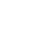

In [40]:
image